## DS 5110 Final Project - Hospital Mortality
### Team 3
### By: Elena Tsvetskova, Brian Chae, Ryan Viti (rrv7eb)

In [1]:
# importing necessary libraries and packages
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col, isnan, when, count, countDistinct, mean
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
import numpy as np

# session initialization
spark = SparkSession.builder \
        .master("local") \
        .appName("Team 3 Final Project") \
        .getOrCreate()

filename = "hospital_mortality.csv"

data = spark.read.csv(filename, inferSchema=True, header=True)
data.count()

91713

In [2]:
# printing original dataset schema
data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

## Data Cleaning and EDA

In [3]:
# empty columns, unique identifiers unnecessary for analysis
data = data.drop("_c83", "encounter_id", "patient_id", "hospital_id", "icu_id", "icu_stay_type")

### Experimenting with NA Origins for Certain Columns

In [4]:
# Quantifying amount of null values in each column of the dataset

data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-------------

In [5]:
# dropping noninvasive measurements due to high frequency of NA and lower accuracy of a noninvasive measurement
condition = lambda col: 'noninvasive' in col
data = data.drop(*filter(condition, data.columns))
# amount of columns remaining after dropping
len(data.columns)

67

In [6]:
# Potential correlation matrix creation using pyspark.ml.stat.Correlation here for numeric variables

We will imbalanced response variable in our ML application.
Helpful link for doing so:
https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [7]:
import matplotlib.pyplot as plt
num_nulls_df=data.withColumn('numNulls', sum(data[col].isNull().cast('int') for col in data.columns))
# num_nulls_df.filter([data[i].isNull()==False for i in s1list]).show()
# num_nulls_df.filter([col(i).isNull()==False for i in s1list])
less_nulls_df = num_nulls_df.filter(col('h1_mbp_min').isNotNull())
# less_nulls = less_nulls.filter(less_nulls.numNulls < 3)
# less_nulls.count()
x = range(1,11)
y = []
for i in range(1, 11):
    y.append(less_nulls_df.filter(less_nulls_df.numNulls < i).count())
# less_nulls_df = num_nulls_df.filter((num_nulls_df.numNulls < 2) and col('h1_mbp_min').isNotNull())
# less_nulls_df.count()

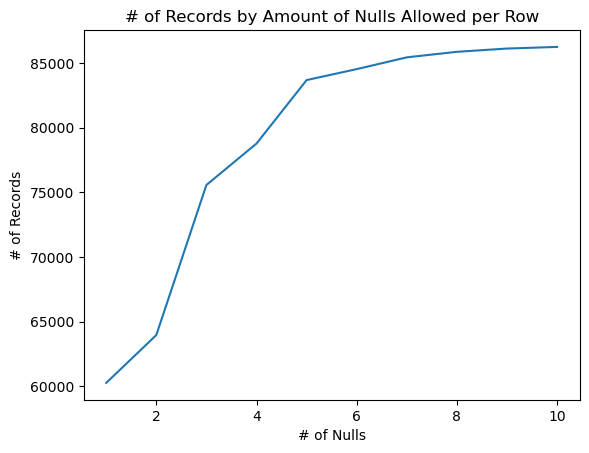

In [8]:
plt.title('# of Records by Amount of Nulls Allowed per Row')
plt.xlabel('# of Nulls')
plt.ylabel('# of Records')
plt.plot(x, y)
plt.show()

In [9]:
# Computing the average number of nulls per row, for reference
num_nulls_column = num_nulls_df.select("numNulls")
filtered = num_nulls_column.filter(col("numNulls")!= 0)
filtered.select(mean(col("numNulls").alias("AVG Nulls/Row"))).show()

+--------------------------------+
|avg(numNulls AS `AVG Nulls/Row`)|
+--------------------------------+
|               4.505564741795981|
+--------------------------------+



Using a threshold of 5 nulls per row, due to apparent elbow in our Records vs. Nulls plot.  Additionally, this was around the average number of nulls present in our previous working version of the dataset.

In [10]:
less_nulls_df = less_nulls_df.filter(less_nulls_df.numNulls < 5)
# dropping these columsn due to having a similar role to our predictor variable, as well as the number of NAs per column weighed against the information provided in a healthcare context
df_cleaned = less_nulls_df.drop("apache_4a_hospital_death_prob", "apache_4a_icu_death_prob", "d1_potassium_max", "d1_potassium_min", "numNulls")

In [11]:
df_cleaned_numRows = df_cleaned.count()
df_cleaned_numRows

83672

### Percentage of Columns containing NA values

In [12]:
df_NAcheck = df_cleaned.select([round((count(when(col(c).isNull(), c))/df_cleaned_numRows),3).alias(c) for c in df_cleaned.columns])
df_NAcheck.show()

+-----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+-----------+-----------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+--------------+--------------+----+---------+-----------------+---------------+-----------------+--------+--------+---------------------------+--------------------+-------------------+--------------+
|  age| bmi|elective_surgery|ethnicity|gender|height|icu_admit_source|icu_type|pre_icu_los_days|weight|apach

In [13]:
print("Number of Columns containing greater than 5% NA values: {}".format([(df_NAcheck.first()[c] > 0.05) for c in df_NAcheck.columns].count(True)))

Number of Columns containing greater than 5% NA values: 0


Single imputation is ill-advised based on multiple research studies when dealing with healthcare data, so we will avoid this and instead, since the ratio of NAs in every column falls below 0.05, we will feasibly to drop the remaining rows containing null values.

In [14]:
print("Number of rows saved via cleaning + EDA: {}".format((df_cleaned.dropna().count()-data.dropna().count())))
df_cleaned = df_cleaned.dropna()

Number of rows saved via cleaning + EDA: 8329


## Feature Engineering and EDA

In [15]:
df_cleaned.groupBy("icu_admit_source").count().show()

+--------------------+-----+
|    icu_admit_source|count|
+--------------------+-----+
|Operating Room / ...|14531|
|Accident & Emergency|40170|
|               Floor|11538|
|      Other Hospital| 1901|
|           Other ICU|  454|
+--------------------+-----+



In [16]:
df_cleaned = df_cleaned.withColumn("icu_admit_source", when(df_cleaned.icu_admit_source== "Other Hospital","Other")
                                 .when(df_cleaned.icu_admit_source== "Other ICU","Other")
                                 .when(df_cleaned.icu_admit_source== "Operating/Recovery", "Operating & Recovery")
                                 .otherwise(df_cleaned.icu_admit_source))
df_cleaned.groupBy("icu_admit_source").count().show()

+--------------------+-----+
|    icu_admit_source|count|
+--------------------+-----+
|Operating Room / ...|14531|
|Accident & Emergency|40170|
|               Floor|11538|
|               Other| 2355|
+--------------------+-----+



Initially, we drop several columns here due to inability to utilize effectively in a machine learning model setting, such as diagnosis codes and variables with extremely skewed distributions which provide no new information.

In [17]:
df_cleaned = df_cleaned.drop("apache_2_diagnosis", "apache_3j_diagnosis", "gcs_unable")

In [18]:
# Printing the updated schema after NA handling
df_cleaned.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: integer (nullable = true)
 |-- d1_

In [19]:
# Creating GCS total score feature from verbal, eyes, and motor scores
df_cleaned = df_cleaned.withColumn("GCS_total", df_cleaned.gcs_eyes_apache + df_cleaned.gcs_verbal_apache + df_cleaned.gcs_motor_apache)

In [20]:
# Distribution of reported diseases
diseases = ["aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "leukemia", "lymphoma", "solid_tumor_with_metastasis"]
for i in diseases:
    df_cleaned.select(i).groupBy(i).count().show()

+----+-----+
|aids|count|
+----+-----+
|   1|   66|
|   0|68528|
+----+-----+

+---------+-----+
|cirrhosis|count|
+---------+-----+
|        1| 1176|
|        0|67418|
+---------+-----+

+-----------------+-----+
|diabetes_mellitus|count|
+-----------------+-----+
|                1|16579|
|                0|52015|
+-----------------+-----+

+---------------+-----+
|hepatic_failure|count|
+---------------+-----+
|              1|  984|
|              0|67610|
+---------------+-----+

+--------+-----+
|leukemia|count|
+--------+-----+
|       1|  521|
|       0|68073|
+--------+-----+

+--------+-----+
|lymphoma|count|
+--------+-----+
|       1|  287|
|       0|68307|
+--------+-----+

+---------------------------+-----+
|solid_tumor_with_metastasis|count|
+---------------------------+-----+
|                          1| 1508|
|                          0|67086|
+---------------------------+-----+



In [21]:
# updating schema for disease variables, casting to boolean type
for name in diseases:
    df_cleaned = df_cleaned.withColumn(name, col(name).cast('boolean'))

In [22]:
# load pyspark modules
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Bucketizer

#Bucketing total GCS score based on accepted ranges for varying degrees of disease
splits = [3, 9, 13, 15]

bucketizer_GCS = Bucketizer(splits=splits, inputCol="GCS_total", outputCol="GCS_buckets")

df_cleaned = bucketizer_GCS.transform(df_cleaned)

#dropping all columns used to create the feature - no longer necessary for analysis
df_cleaned = df_cleaned.drop("GCS_total", "gcs_motor_apache", "gcs_verbal_apache", "gcs_eyes_apache")

In [23]:
# Outcome variable distribution
df_cleaned.groupBy("hospital_death").count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1| 5603|
|             0|62991|
+--------------+-----+



A large amount of categories with no feasible way to bucket them - we will drop these two columns due to the nature of the problem.

In [24]:
df_cleaned.groupBy("apache_3j_bodysystem").count().show()

+--------------------+-----+
|apache_3j_bodysystem|count|
+--------------------+-----+
|        Neurological| 8914|
|Musculoskeletal/Skin|  845|
|       Genitourinary| 1669|
|       Gynecological|  231|
|              Sepsis| 9378|
|       Hematological|  483|
|           Metabolic| 5886|
|      Cardiovascular|22446|
|              Trauma| 2870|
|    Gastrointestinal| 6933|
|         Respiratory| 8939|
+--------------------+-----+



In [25]:
df_cleaned.groupBy("apache_2_bodysystem").count().show()

+-------------------+-----+
|apache_2_bodysystem|count|
+-------------------+-----+
|Undefined diagnoses| 3067|
|       Haematologic|  483|
|Renal/Genitourinary| 1886|
|          Metabolic| 5886|
|         Neurologic| 8914|
|Undefined Diagnoses|  247|
|     Cardiovascular|29369|
|             Trauma| 2870|
|   Gastrointestinal| 6933|
|        Respiratory| 8939|
+-------------------+-----+



In [26]:
# Collapsing categories that have same meaning
df_cleaned = df_cleaned.withColumn("apache_2_bodysystem", when(df_cleaned.apache_2_bodysystem=="Undefined Diagnoses", "Undefined diagnoses")
                                                         .otherwise(df_cleaned.apache_2_bodysystem))
df_cleaned.groupBy("apache_2_bodysystem").count().show()

+-------------------+-----+
|apache_2_bodysystem|count|
+-------------------+-----+
|Undefined diagnoses| 3314|
|       Haematologic|  483|
|Renal/Genitourinary| 1886|
|          Metabolic| 5886|
|         Neurologic| 8914|
|     Cardiovascular|29369|
|             Trauma| 2870|
|   Gastrointestinal| 6933|
|        Respiratory| 8939|
+-------------------+-----+



In [27]:
df_cleaned.select([column for column in df_cleaned.columns if F.count(F.when(df_cleaned[column] == 0 or df_cleaned[column] == 1, column)).alias(column) for column in df.columns]).show()

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

#### Finding binary columns and coercing them to binary data type

In [28]:
binary_check = df_cleaned.select([F.count(F.when(df_cleaned[column] == 0, column).when(df_cleaned[column] == 1, column)).alias(column) for column in df_cleaned.columns])
binary_columns = [column for column in binary_check.columns if binary_check.first()[column]==df_cleaned.count()]
for name in binary_columns:
    df_cleaned = df_cleaned.withColumn(name, col(name).cast('boolean'))
df_cleaned.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: boolean (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_post_operative: boolean (nullable = true)
 |-- arf_apache: boolean (nullable = true)
 |-- gcs_unable_apache: boolean (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: boolean (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: boolean (nullable = true)
 |-- d1_diasbp_max: integer (nullable = true)
 |-- d1_diasbp_min: integer (nullable = true)
 |-- d1_heartrate_max: integer (nullable = true)
 |-- d1_heartr

In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df_cleaned.dtypes if item[1].startswith('string') ]

#define a list of stageJs in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the stages list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df_cleaned)
#transform the dataframe
df= pipelineModel.transform(df_cleaned)
df.take(2)

[Row(age=68, bmi=22.73, elective_surgery=False, ethnicity='Caucasian', gender='M', height=180.3, icu_admit_source='Floor', icu_type='CTICU', pre_icu_los_days=0.541666667, weight=73.9, apache_post_operative=False, arf_apache=False, gcs_unable_apache=False, heart_rate_apache=118, intubated_apache=False, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=False, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, aids=False, cirrhosis=False, diabetes_mellitus=True, hepatic_failure=False, immunosuppression=False, leuk

In [30]:
df_2 = df.drop("ethnicity", "gender", "icu_admit_source", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem")
df_2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: boolean (nullable = true)
 |-- height: double (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_post_operative: boolean (nullable = true)
 |-- arf_apache: boolean (nullable = true)
 |-- gcs_unable_apache: boolean (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: boolean (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: boolean (nullable = true)
 |-- d1_diasbp_max: integer (nullable = true)
 |-- d1_diasbp_min: integer (nullable = true)
 |-- d1_heartrate_max: integer (nullable = true)
 |-- d1_heartrate_min: integer (nullable = true)
 |-- d1_mbp_max: integer (nullable = true)
 |-- d1_mbp_min: integer (nullable = true)
 |-- d1_resprate_max: integer (nullable = true

In [31]:
#feature_columns = df_2.select([c for c in df_2.columns if c not in {'hospital_death'}])
#feature_columns.take(1)

va = VectorAssembler(inputCols=[c for c in df_2.columns if c not in {'hospital_death'}], outputCol="features")  
output = va.transform(df_2)
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(output)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(output)
df_scaled.take(5)

[Row(age=68, bmi=22.73, elective_surgery=False, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_post_operative=False, arf_apache=False, gcs_unable_apache=False, heart_rate_apache=118, intubated_apache=False, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=False, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, aids=False, cirrhosis=False, diabetes_mellitus=True, hepatic_failure=False, immunosuppression=False, leukemia=False, lymphoma=False, solid_tumor_with_metastasis=False, hospital_death=F

### Principal Component Analysis

In [32]:
from pyspark.ml.feature import PCA

# PCA using 4 components
pca = PCA(k=6, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_scaled)

# extract the transformed features
result = model.transform(df_scaled)

result.take(1)

[Row(age=68, bmi=22.73, elective_surgery=False, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_post_operative=False, arf_apache=False, gcs_unable_apache=False, heart_rate_apache=118, intubated_apache=False, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=False, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, aids=False, cirrhosis=False, diabetes_mellitus=True, hepatic_failure=False, immunosuppression=False, leukemia=False, lymphoma=False, solid_tumor_with_metastasis=False, hospital_death=F

In [33]:
import numpy as np

np.round(100.00*model.explainedVariance.toArray(),4)

array([12.5142,  8.5187,  5.5308,  5.0157,  4.1663,  3.7949])

In [34]:
import pandas as pd

cols = df_2.drop('hospital_death').columns
cols

pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], index = cols)
df_pc

,PC1,PC2,PC3,PC4,PC5,PC6
age,-0.0432,0.0695,-0.0860,0.1977,-0.0558,0.1919
bmi,0.0256,-0.0041,-0.0634,0.0261,-0.3524,-0.3086
elective_surgery,-0.0607,0.1392,-0.0922,-0.3070,-0.2116,0.2233
height,0.0346,0.0261,-0.0124,-0.0871,-0.2342,-0.1974
pre_icu_los_days,-0.0363,-0.0268,-0.0356,-0.0695,-0.1005,0.1451
weight,0.0398,0.0077,-0.0652,-0.0134,-0.4317,-0.3718
apache_post_operative,-0.0614,0.1352,-0.0987,-0.3240,-0.2049,0.2168
arf_apache,-0.0021,0.0028,-0.0360,0.0379,0.0196,-0.0095
gcs_unable_apache,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
heart_rate_apache,-0.0062,-0.3547,0.0045,-0.1831,0.0202,-0.0027


In [35]:
pc1 = df_pc.loc[:,'PC1'].abs().sort_values(ascending=False)
s1 = pc1[pc1 > 0.2]
s1

h1_mbp_min       0.3231
h1_mbp_max       0.3092
h1_sysbp_min     0.3006
h1_diasbp_min    0.2967
h1_sysbp_max     0.2886
h1_diasbp_max    0.2752
d1_mbp_min       0.2597
d1_mbp_max       0.2579
d1_sysbp_min     0.2498
d1_sysbp_max     0.2486
d1_diasbp_min    0.2400
map_apache       0.2272
d1_diasbp_max    0.2127
Name: PC1, dtype: float64

In [36]:
s1index=s1.index
s1list = list(s1index)
s1list

['h1_mbp_min',
 'h1_mbp_max',
 'h1_sysbp_min',
 'h1_diasbp_min',
 'h1_sysbp_max',
 'h1_diasbp_max',
 'd1_mbp_min',
 'd1_mbp_max',
 'd1_sysbp_min',
 'd1_sysbp_max',
 'd1_diasbp_min',
 'map_apache',
 'd1_diasbp_max']

In [37]:
pc2 = df_pc.loc[:,'PC2'].abs().sort_values(ascending=False)
s2 = pc2[pc2 > 0.2]
s2

h1_heartrate_max     0.3792
h1_heartrate_min     0.3675
d1_heartrate_max     0.3653
heart_rate_apache    0.3547
d1_heartrate_min     0.2804
h1_resprate_max      0.2476
h1_resprate_min      0.2267
Name: PC2, dtype: float64

In [38]:
s2index=s2.index
s2index

Index(['h1_heartrate_max', 'h1_heartrate_min', 'd1_heartrate_max',
       'heart_rate_apache', 'd1_heartrate_min', 'h1_resprate_max',
       'h1_resprate_min'],
      dtype='object')

In [39]:
pc3 = df_pc.loc[:,'PC3'].abs().sort_values(ascending=False)
s3 = pc3[pc3 > 0.2]
s3

ventilated_apache    0.3085
intubated_apache     0.2711
GCS_buckets          0.2705
d1_temp_min          0.2496
d1_mbp_max           0.2387
d1_diasbp_max        0.2358
d1_resprate_min      0.2307
d1_sysbp_max         0.2266
temp_apache          0.2139
Name: PC3, dtype: float64

In [40]:
s3index=s3.index
s3index

Index(['ventilated_apache', 'intubated_apache', 'GCS_buckets', 'd1_temp_min',
       'd1_mbp_max', 'd1_diasbp_max', 'd1_resprate_min', 'd1_sysbp_max',
       'temp_apache'],
      dtype='object')

In [41]:
#Union the series indices

important_vars = s3index.union(s2index).union(s1index)
list(important_vars)

['GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'heart_rate_apache',
 'intubated_apache',
 'map_apache',
 'temp_apache',
 'ventilated_apache']

In [42]:
#for i in list(important_vars):
#    less_nulls_df.describe(i).show()
#    less_nulls_df.select(F.percentile_approx(i, [0.25, 0.75], 100000).alias(i+"_quantiles")).show()

### Checking for collinearity amongst our important variables

In [43]:
# first subset our important variables/columns from original df

df_important_vars = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'heart_rate_apache',
 'intubated_apache',
 'map_apache',
 'temp_apache',
 'ventilated_apache')

df_important_vars.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, h1_sysbp_min=115, heart_rate_apache=118, intubated_apache=False, map_apache=40, temp_apache=39.3, ventilated_apache=False),
 Row(GCS_buckets=0.0, d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_max=118, d1_heartrate_min=72, d1_mbp_max=120, d1_mbp_min=38, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_diasbp_min=48, h1_heartrate_max=114, h1_heartrate_min=100, h1_mbp_max=85, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, h1_sysbp_min=71, heart_rate_apache=120, intubated_apache=False, map_apache=46, temp_apache=35.1, ventilated_apache=True)]

In [44]:
features = df_important_vars.rdd.map(lambda row: row[0:])

In [45]:
from pyspark.mllib.stat import Statistics

corr_mat = Statistics.corr(features, method='spearman')

In [46]:
col_names = df_important_vars.columns

corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,GCS_buckets,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_min,d1_sysbp_max,d1_sysbp_min,...,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_sysbp_max,h1_sysbp_min,heart_rate_apache,intubated_apache,map_apache,temp_apache,ventilated_apache
GCS_buckets,1.000000,-0.017135,0.104490,-0.158100,-0.016801,-0.009172,0.135446,0.037313,-0.018202,0.172461,...,0.115159,0.004088,0.018805,0.018428,0.137519,-0.119817,-0.455115,0.038859,0.084065,-0.560644
d1_diasbp_max,-0.017135,1.000000,0.164635,0.176458,-0.027199,0.826313,0.139542,-0.051391,0.585959,0.111693,...,0.333586,0.108730,0.028031,0.413791,0.275060,0.123766,-0.054468,0.364922,0.013839,-0.042832
d1_diasbp_min,0.104490,0.164635,1.000000,-0.081069,0.115692,0.250742,0.875331,0.115479,0.155180,0.650670,...,0.589404,-0.054965,0.029526,0.279538,0.429437,-0.004455,-0.105187,0.474764,0.080017,-0.136519
d1_heartrate_max,-0.158100,0.176458,-0.081069,1.000000,0.550525,0.094915,-0.150337,0.068540,0.007558,-0.228894,...,-0.079152,0.264757,0.188423,-0.059938,-0.151071,0.852595,0.104529,-0.029311,0.083214,0.161908
d1_heartrate_min,-0.016801,-0.027199,0.115692,0.550525,1.000000,-0.071458,0.060305,0.242667,-0.141724,-0.004212,...,-0.001960,0.159744,0.226514,-0.121812,-0.064894,0.606681,0.011882,-0.014101,0.168925,0.032118
d1_mbp_max,-0.009172,0.826313,0.250742,0.094915,-0.071458,1.000000,0.286184,-0.044862,0.740401,0.254180,...,0.462410,0.123607,0.028139,0.540906,0.403164,0.062416,-0.057906,0.487436,0.012319,-0.039664
d1_mbp_min,0.135446,0.139542,0.875331,-0.150337,0.060305,0.286184,1.000000,0.125034,0.258598,0.790573,...,0.642015,-0.045484,0.029548,0.373866,0.527022,-0.065775,-0.145585,0.532311,0.084044,-0.174435
d1_resprate_min,0.037313,-0.051391,0.115479,0.068540,0.242667,-0.044862,0.125034,1.000000,-0.043349,0.126249,...,0.081512,0.308906,0.590620,-0.021397,0.079001,0.142290,-0.074182,0.032901,0.118174,-0.061322
d1_sysbp_max,-0.018202,0.585959,0.155180,0.007558,-0.141724,0.740401,0.258598,-0.043349,1.000000,0.361491,...,0.418009,0.072345,0.005429,0.693431,0.523316,-0.030000,-0.037428,0.435874,0.023270,-0.018233
d1_sysbp_min,0.172461,0.111693,0.650670,-0.228894,-0.004212,0.254180,0.790573,0.126249,0.361491,1.000000,...,0.565936,-0.088807,0.016400,0.480801,0.654893,-0.146189,-0.173850,0.461744,0.107404,-0.207091


In [47]:
corr_df = corr_df[corr_df < 1].unstack().transpose()\
        .sort_values( ascending=False)\
        .drop_duplicates()

corr_df 

h1_mbp_min         h1_diasbp_min       0.882091
h1_heartrate_max   h1_heartrate_min    0.876911
d1_diasbp_min      d1_mbp_min          0.875331
d1_temp_min        temp_apache         0.856924
h1_diasbp_max      h1_mbp_max          0.853943
                                         ...   
ventilated_apache  d1_sysbp_min       -0.207091
d1_sysbp_min       d1_heartrate_max   -0.228894
intubated_apache   GCS_buckets        -0.455115
ventilated_apache  GCS_buckets        -0.560644
GCS_buckets        GCS_buckets              NaN
Length: 326, dtype: float64

In [48]:
corr_df_final = corr_df[abs(corr_df) >= 0.7]

corr_df_final

h1_mbp_min         h1_diasbp_min        0.882091
h1_heartrate_max   h1_heartrate_min     0.876911
d1_diasbp_min      d1_mbp_min           0.875331
d1_temp_min        temp_apache          0.856924
h1_diasbp_max      h1_mbp_max           0.853943
d1_heartrate_max   heart_rate_apache    0.852595
d1_diasbp_max      d1_mbp_max           0.826313
h1_mbp_min         h1_sysbp_min         0.817754
d1_mbp_min         d1_sysbp_min         0.790573
h1_heartrate_max   d1_heartrate_max     0.788672
h1_sysbp_max       h1_mbp_max           0.785481
                   h1_sysbp_min         0.743895
heart_rate_apache  h1_heartrate_max     0.741193
d1_mbp_max         d1_sysbp_max         0.740401
d1_heartrate_min   h1_heartrate_min     0.729707
h1_mbp_max         h1_mbp_min           0.721652
h1_heartrate_min   heart_rate_apache    0.704668
dtype: float64

#### Highly correlated variables to remove

##### h1_diasbp_min
##### h1_heartrate_min
##### d1_mbp_min
##### temp_apache
##### h1_mbp_max
##### heart_rate_apache
##### d1_mbp_max
##### h1_sysbp_min
##### d1_heartrate_max


In [49]:
final_vars = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache')

final_vars.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_min=72, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_heartrate_max=119, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, intubated_apache=False, map_apache=40, ventilated_apache=False),
 Row(GCS_buckets=0.0, d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_min=72, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_heartrate_max=114, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, intubated_apache=False, map_apache=46, ventilated_apache=True)]

In [50]:
final_features = final_vars.rdd.map(lambda row: row[0:])
final_corr_mat = Statistics.corr(final_features, method='spearman')

final_col_names = final_vars.columns

final_corr_df = pd.DataFrame(final_corr_mat)
final_corr_df.index, final_corr_df.columns = final_col_names, final_col_names

final_corr_df

,GCS_buckets,d1_diasbp_max,d1_diasbp_min,d1_heartrate_min,d1_resprate_min,d1_sysbp_max,d1_sysbp_min,d1_temp_min,h1_diasbp_max,h1_heartrate_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_sysbp_max,intubated_apache,map_apache,ventilated_apache
GCS_buckets,1.000000,-0.017135,0.104490,-0.016801,0.037313,-0.018202,0.172461,0.090756,-0.012824,-0.105937,0.115159,0.004088,0.018805,0.018428,-0.455115,0.038859,-0.560644
d1_diasbp_max,-0.017135,1.000000,0.164635,-0.027199,-0.051391,0.585959,0.111693,0.002803,0.609764,0.123098,0.333586,0.108730,0.028031,0.413791,-0.054468,0.364922,-0.042832
d1_diasbp_min,0.104490,0.164635,1.000000,0.115692,0.115479,0.155180,0.650670,0.097097,0.383814,-0.010357,0.589404,-0.054965,0.029526,0.279538,-0.105187,0.474764,-0.136519
d1_heartrate_min,-0.016801,-0.027199,0.115692,1.000000,0.242667,-0.141724,-0.004212,0.168904,0.002726,0.622956,-0.001960,0.159744,0.226514,-0.121812,0.011882,-0.014101,0.032118
d1_resprate_min,0.037313,-0.051391,0.115479,0.242667,1.000000,-0.043349,0.126249,0.132328,-0.016652,0.132575,0.081512,0.308906,0.590620,-0.021397,-0.074182,0.032901,-0.061322
d1_sysbp_max,-0.018202,0.585959,0.155180,-0.141724,-0.043349,1.000000,0.361491,0.013291,0.433809,-0.044464,0.418009,0.072345,0.005429,0.693431,-0.037428,0.435874,-0.018233
d1_sysbp_min,0.172461,0.111693,0.650670,-0.004212,0.126249,0.361491,1.000000,0.127386,0.260565,-0.159573,0.565936,-0.088807,0.016400,0.480801,-0.173850,0.461744,-0.207091
d1_temp_min,0.090756,0.002803,0.097097,0.168904,0.132328,0.013291,0.127386,1.000000,0.023757,0.116832,0.077532,0.056688,0.110457,0.038281,-0.106840,0.037532,-0.130992
h1_diasbp_max,-0.012824,0.609764,0.383814,0.002726,-0.016652,0.433809,0.260565,0.023757,1.000000,0.153073,0.607920,0.110581,-0.000171,0.632958,-0.040628,0.389114,-0.034939
h1_heartrate_max,-0.105937,0.123098,-0.010357,0.622956,0.132575,-0.044464,-0.159573,0.116832,0.153073,1.000000,-0.033970,0.331267,0.242316,-0.025699,0.068560,-0.024786,0.112015


In [51]:
final_corr_df = final_corr_df[final_corr_df < 1].unstack().transpose()\
                .sort_values( ascending=False)\
                .drop_duplicates()

corr_df_test = final_corr_df[abs(final_corr_df) >= 0.7]
corr_df_test #testing to ensure we now have no correlation coefficients > 0.7

Series([], dtype: float64)

### Outliers in our key variables

In [95]:
final_integer_vars = df_2.select('d1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'map_apache')

final_integer_vars.take(2)

[Row(d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_min=72, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_heartrate_max=119, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, map_apache=40),
 Row(d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_min=72, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_heartrate_max=114, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, map_apache=46)]

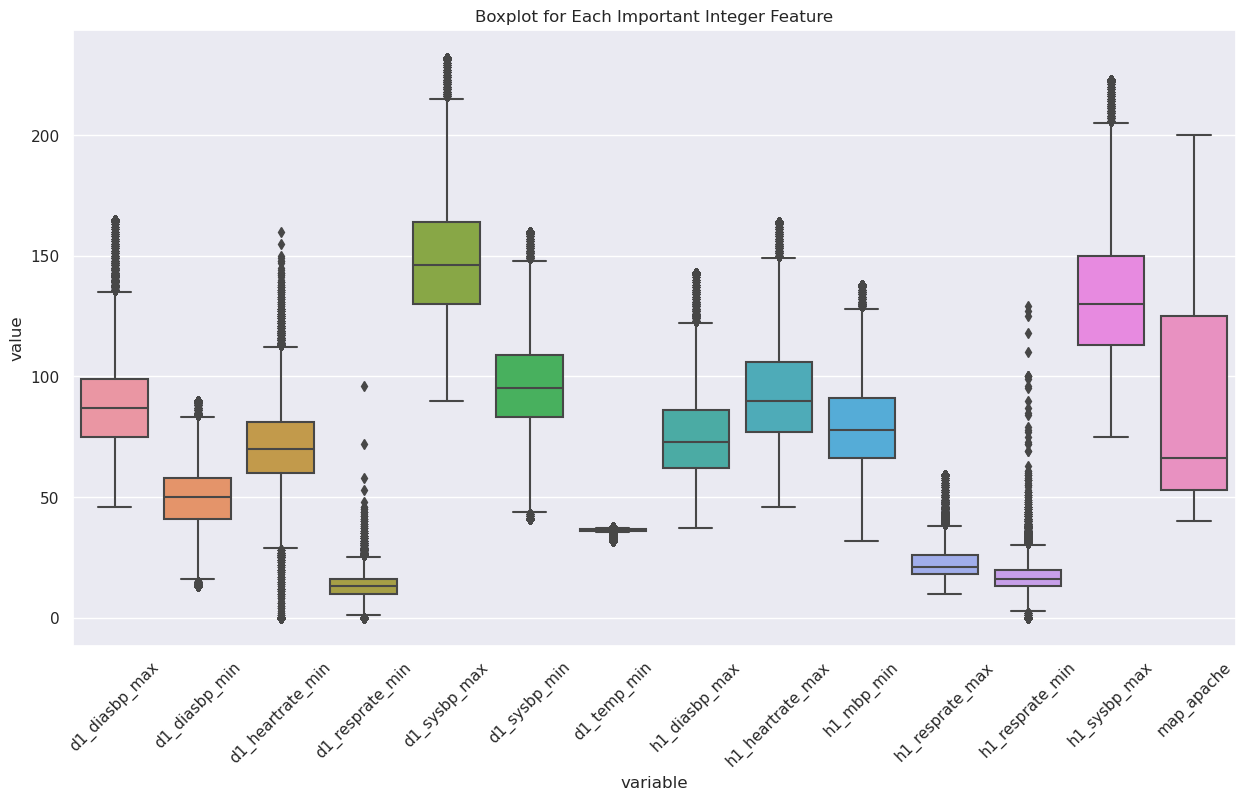

In [111]:
import seaborn as sns

sns.set_theme(style="darkgrid")
final_integer_vars_pd = final_integer_vars.toPandas()
df_plot = final_integer_vars_pd.melt()
df_plot
plt.figure(figsize=(15,8))
sns.boxplot(x='variable', y='value', data=df_plot).set(title='Boxplot for Each Important Integer Feature')
plt.xticks(rotation=45)
plt.show()

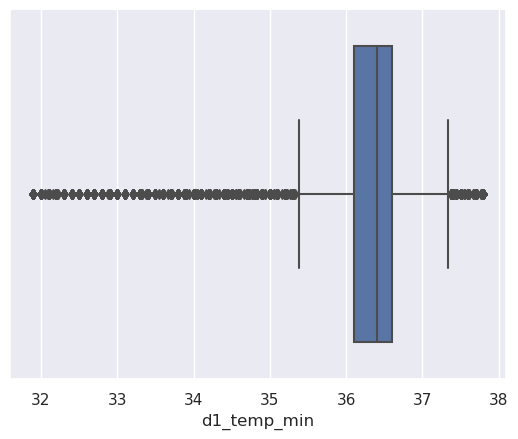

In [112]:
sns.set_theme(style="darkgrid")
sns.boxplot(x='d1_temp_min', data=final_integer_vars_pd)
plt.show()

In [102]:
final_vars_with_hos_death = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache',
 'hospital_death')

final_vars_with_hos_death.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_min=72, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_heartrate_max=119, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, intubated_apache=False, map_apache=40, ventilated_apache=False, hospital_death=False),
 Row(GCS_buckets=0.0, d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_min=72, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_heartrate_max=114, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, intubated_apache=False, map_apache=46, ventilated_apache=True, hospital_death=False)]

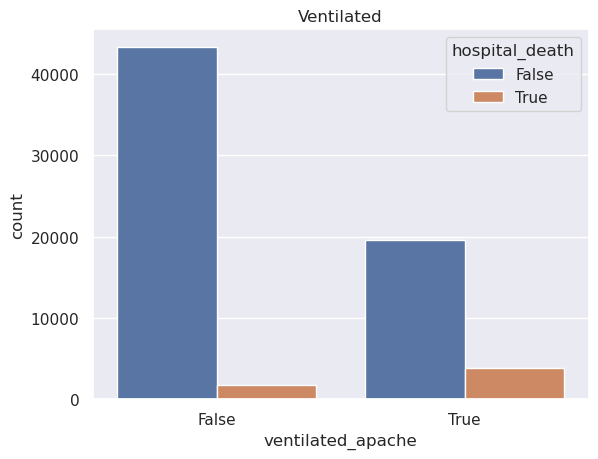

In [109]:
final_vars_with_hos_death_pd = final_vars_with_hos_death.toPandas()

sns.set_theme(style="darkgrid")
sns.countplot(x= 'ventilated_apache', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Ventilated')
plt.show()

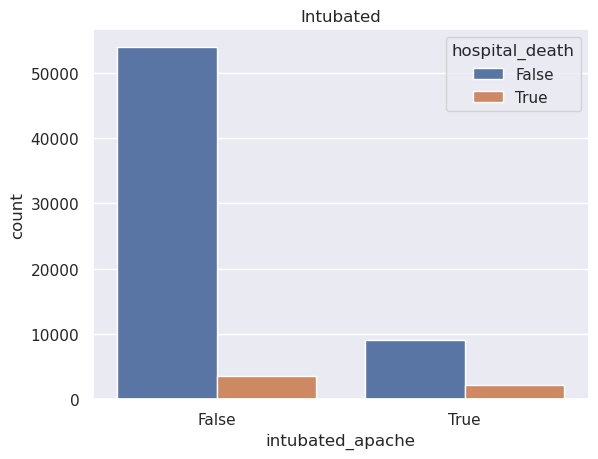

In [110]:
final_vars_with_hos_death_pd = final_vars_with_hos_death.toPandas()

sns.set_theme(style="darkgrid")
sns.countplot(x= 'intubated_apache', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Intubated')
plt.show()

<Figure size 1500x1500 with 0 Axes>

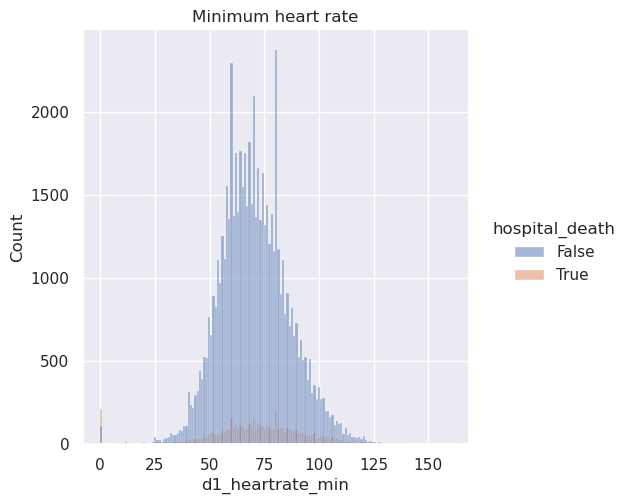

In [136]:
sns.set_theme(style="darkgrid")
sns.displot(x='d1_heartrate_min', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Minimum heart rate')
plt.show()

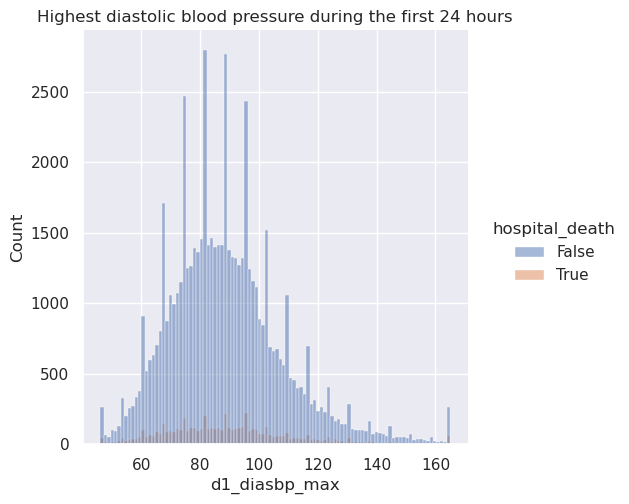

In [142]:
sns.set_theme(style="darkgrid")
sns.displot(x='d1_diasbp_max', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Highest diastolic blood pressure during the first 24 hours')
plt.show()

### Addressing our Imbalanced Data Set

In [36]:
# Outcome variable distribution
df.groupBy("hospital_death").count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|          true| 5603|
|         false|62991|
+--------------+-----+



In [106]:
from pyspark.sql.functions import col

def downsample(df, target, positive_label, negative_label):
    """
    df              spark dataframe
    target          str, target variable
    positive_label  int, value of positive label
    negative_label  int, value of negative label
    
    """

    major_df = df.filter(col(target) == positive_label)
    minor_df = df.filter(col(target) == negative_label)
    major_count = major_df.count()
    minor_count = minor_df.count() 
    if major_count > minor_count:
        ratio = minor_count/major_count
        sampled_df = major_df.sample(True, ratio,seed=seed)
        df_b = sampled_df.unionAll(minor_df)
    elif minor_count > major_count:
        ratio = major_count/minor_count
        sampled_df = minor_df.sample(True, ratio,seed=seed)
        df_b = sampled_df.unionAll(major_df)
    else:
        
        df_b = df
    return df_b

In [107]:
target = 'hospital_death'
positive_label = True
negative_label = False

seed = 314

In [108]:
# Call your downsample function here, and show the count by label

balanced_df = downsample(df,target,positive_label,negative_label)

# compute distribution of target variable
balanced_df.groupBy(target).count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|          true| 5603|
|         false| 5527|
+--------------+-----+



## Model Building and Evaluation

### Logistic Regression - Benchmark model

In [115]:
df_subset = balanced_df.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache',
 'hospital_death')

df_subset= df_subset.withColumn('hospital_death', F.when(df_subset.hospital_death == False, 0).otherwise(1))

df_subset.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=62, d1_heartrate_min=92, d1_resprate_min=16, d1_sysbp_max=113, d1_sysbp_min=106, d1_temp_min=36.3, h1_diasbp_max=68, h1_heartrate_max=116, h1_mbp_min=69, h1_resprate_max=30, h1_resprate_min=16, h1_sysbp_max=113, intubated_apache=False, map_apache=63, ventilated_apache=False, hospital_death=0),
 Row(GCS_buckets=2.0, d1_diasbp_max=102, d1_diasbp_min=64, d1_heartrate_min=68, d1_resprate_min=19, d1_sysbp_max=199, d1_sysbp_min=138, d1_temp_min=36.7, h1_diasbp_max=79, h1_heartrate_max=76, h1_mbp_min=101, h1_resprate_max=28, h1_resprate_min=19, h1_sysbp_max=165, intubated_apache=False, map_apache=162, ventilated_apache=False, hospital_death=0)]

In [116]:
from pyspark.ml.classification import LogisticRegression

training_fraction = [0.8,0.2]
seed = 314
train_data, test_data = df_subset.randomSplit(training_fraction, seed=seed)

va = VectorAssembler(inputCols=[c for c in df_subset.columns if c not in {'hospital_death'}], outputCol="features")  
sc = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr = LogisticRegression(labelCol='hospital_death', featuresCol='scaledFeatures', fitIntercept=True)

# Fit the pipeline
pipeline = Pipeline(stages=[va, sc, lr])
log_model = pipeline.fit(train_data)

In [117]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

log_pred = log_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction", metricName='areaUnderROC')
print('Test Area under ROC curve', evaluator.evaluate(log_pred))

evaluator_2 = MulticlassClassificationEvaluator(labelCol='hospital_death', predictionCol="prediction")
print('Test Accuracy', evaluator_2.evaluate(log_pred,{evaluator_2.metricName: "accuracy"}))


Test Area under ROC curve 0.7372838357961693
Test Accuracy 0.7377049180327869


### Optimizing our Logistic Regression with Parameter Tuning and Cross Validation

In [118]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.5, 2.0 ]) \
    .addGrid(lr.maxIter, [5, 10, 100, 200]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.setParallelism(4).fit(train_data) # train 4 models in parallel

print("train time:", time.time() - t0)


train time: 199.16564178466797


In [55]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='LogisticRegression_9e38e0c72fa2', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_9e38e0c72fa2', name='maxIter', doc='max number of iterations (>= 0).'): 5}


In [56]:
cv_log_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_log_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_log_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7256968116688188
Test Accuracy 0.7254098360655737


### Gradient Boosting

In [120]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='hospital_death', featuresCol='scaledFeatures', maxIter=10)

pipeline = Pipeline(stages=[va, sc, gbt])

gbt_model = pipeline.fit(train_data)

In [50]:
gbt_pred = gbt_model.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7256968116688188
Test Accuracy 0.7254098360655737


##### Since decision trees are immune to multicollinearity, let's see how the tree performs with all of the features

In [60]:
balanced_df = balanced_df.withColumn('hospital_death', F.when(balanced_df.hospital_death == False, 0).otherwise(1))

training_fraction = [0.8,0.2]
seed = 314
train_all_vars, test_all_vars = balanced_df.randomSplit(training_fraction, seed=seed)

gbt = GBTClassifier(labelCol='hospital_death', featuresCol='scaledFeatures', maxIter=10)

pipeline = Pipeline(stages=[va, sc, gbt])

gbt_model = pipeline.fit(train_all_vars)

In [61]:
gbt_pred = gbt_model.transform(test_all_vars)

print('Test Area under ROC curve', evaluator.evaluate(gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7395886185005418
Test Accuracy 0.7390710382513661


##### We are going to continue to move forward with the simpler model with fewer features

### Optimizing the parameters of our Gradient Boosted Trees Implementation

##### Due to runtime (and we can run the trees in parallel), we are going to break the pararm grid into parts 

#### First, testing different max depths

In [121]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.fit(train_data)

print("train time:", time.time() - t0)

train time: 119.88920879364014


In [122]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_e20a37aab7fd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}


In [123]:
cv_gbt_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7256968116688188
Test Accuracy 0.7254098360655737


#### Next, testing different max bins

In [124]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxBins, [10, 20, 40]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.fit(train_data)

print("train time:", time.time() - t0)

train time: 88.86569380760193


In [125]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_e20a37aab7fd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10}


In [126]:
cv_gbt_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7283707083750264
Test Accuracy 0.7281420765027322


#### Next, testing different max iterations

In [127]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10, 20]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.fit(train_data)

print("train time:", time.time() - t0)

train time: 101.09356212615967


In [128]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_e20a37aab7fd', name='maxIter', doc='max number of iterations (>= 0).'): 20}


In [129]:
cv_gbt_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7295079448778685
Test Accuracy 0.7295081967213115


#### We are going to continue with our GBT with max depth at 5, max bins at 10, and max iterations at 20

In [130]:
gbt = GBTClassifier(labelCol='hospital_death', featuresCol='scaledFeatures', maxDepth=5, maxBins=10, maxIter=20)

pipeline = Pipeline(stages=[va, sc, gbt])

gbt_model = pipeline.fit(train_data)

gbt_pred = gbt_model.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7318642125498761
Test Accuracy 0.7317850637522769


### Random Forest

**Note: not addressed to adhere completely to our own variables just yet, only for reference**

In [ ]:
# Importing necessary ML libraries and packages
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="hospital_death", featuresCol="indexedFeatures")
pipeline = Pipeline(stages=[assembler, rf])
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 5)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

(trainingData, testData) = df.randomSplit([0.8, 0.2])